# Time Series com Python




In [1]:
# importa as bibliotecas que serão usadas
import pandas as pd
from pandas import read_csv
from pandas import concat
from matplotlib import pyplot
import pandas.util.testing as tm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot

C:\Users\Marcio Rodrigues\AppData\Local\Temp\ipykernel_9852\2169691655.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# ler a base de dados usada.
series = read_csv('champagne_sales.csv', header=0, index_col=0, parse_dates=True).squeeze(1)

## Projeto: Prevendo dados futuros.

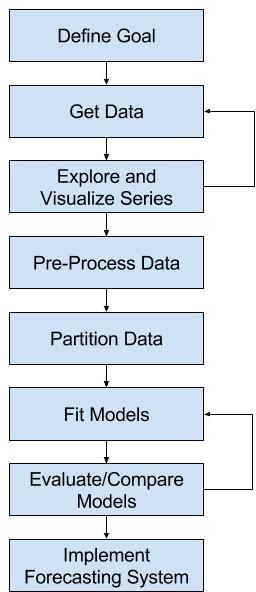

In [3]:
from IPython.display import Image
Image('time_series_project.png')

**Boas Práticas**

*   Comece com um baseline simples para ter referência.
*   Faça uma análise de dados antes de iniciar previsão de valores.
*   Teste Modelos difentes e avalie:
  - Complexidade.
  - Intepretabilidade.
  - Custo computacional.
*   Faça teste A/B antes de colocar em produção sua solução.

**Separando os dados para treino, teste e validação**

Vamos separar dois arquivos fisicos:

  - **dataset.csv**: Dados de 1964 a setembro de 1971.

  - **validation.csv**: Dados de Outubro de 1971 a Outubro de 1972 (1 ano de vendas).

In [4]:
# pega a quantidade de linhas e subtrai por 12
split_point = len(series) - 12

In [5]:
# define que a variável dataset vai conter linhas até o split_point
dataset = series[0:split_point]

In [6]:
# define que a variável validation terá os dados do split_point em diante
validation = series[split_point:]

In [7]:
# imprime o tamanho dos conjuntos
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))

Dataset 93, Validation 12


In [8]:
# escreve para o disco
dataset.to_csv('dataset.csv')

In [9]:
# escreve para o disco.
validation.to_csv('validation.csv')

**Analise de Dados**

In [12]:
import pandas as pd
series = pd.read_csv('dataset.csv', header=0, index_col=0, parse_dates=True).squeeze(1)

In [13]:
series.describe()

count       93.000000
mean      4641.118280
std       2486.403841
min       1573.000000
25%       3036.000000
50%       4016.000000
75%       5048.000000
max      13916.000000
Name: Sales, dtype: float64

*   A média é de 4,641 isso significa em o nível da nossa série é de 4,641 vendas em média.
*   O desvio padrão é relativamente alto 2,486 vendas variando a partir da média.
*   Os quartis juntamente com o desvio padrão nos mostra que os dados estão espalhados da média.

<AxesSubplot:xlabel='Month'>

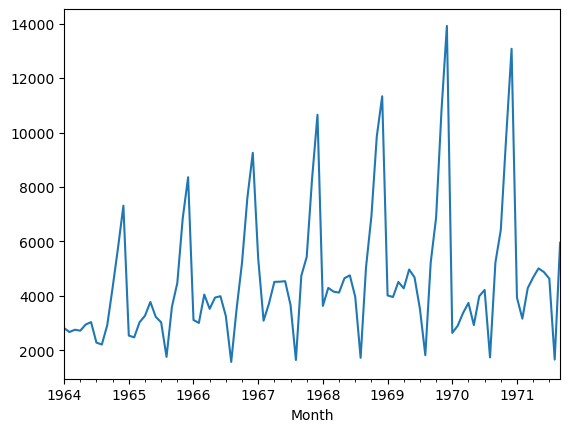

In [14]:
# Dados na linha do tempo
series.plot()

   - Aparentemente existe um aumento de tendência de vendas ao longo dos anos.
   - Aparentemente existe uma sazonalidade nas vendas por anos.
   - Aparentemente a amplitude da sazonalidade aumenta conforme a tendência, isso pode sugerir um relacionamento multiplicativo.
   - Aparentemente não existe qualquer outlier.
   - Como vimos que há uma tendência e uma sazonalidade (obvias) isso nos dá forte indício que estamos trabalhando com uma série não estacionária.

**Visualizando a Sazonalidade**

Podemos confirmar nossa suposição de que a sazonalidae é anual. No código abaixo plotamos os dados agrupados por ano para visualizar as vendas de cada ano. 


In [16]:
from pandas import DataFrame
from pandas import Grouper

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

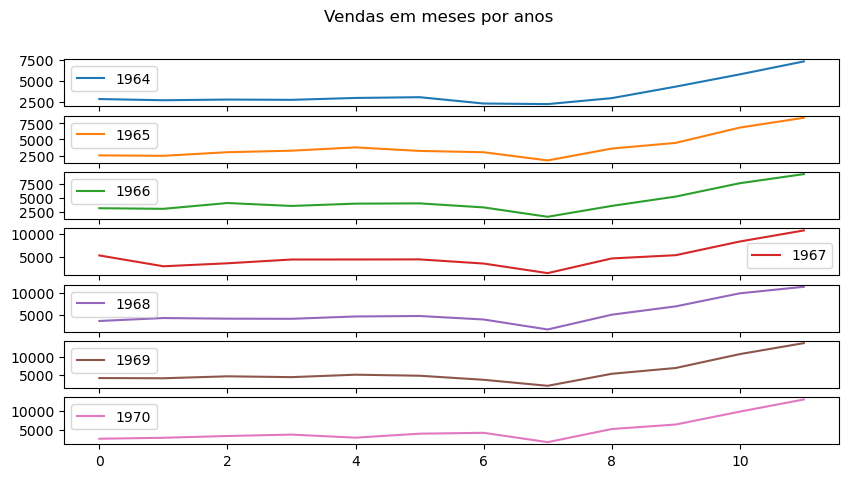

In [17]:
grupos = series['1964':'1970'].groupby(Grouper(freq='A'))
anos = DataFrame()
for nome, grupo in grupos:
    anos[nome.year] = grupo.values

anos.plot(figsize=(10,5)
          ,subplots=True
          ,title='Vendas em meses por anos')

- Podemos ver claramente que as vendas caiem em agosto e aumentam do final do mês seguinte até o final do ano. Isso se repete a cada ano.

**Plotando a distribuição da Série**
-  A distribuição não é uma normal.
-  A forma tem uma longa cauda a direita. Isso pode sugerir algum tipo de transformação.

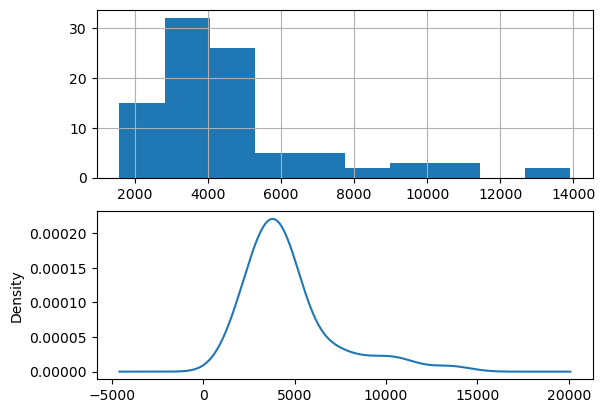

In [18]:
# Distribuição da Série
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

**Visualizando Autocorrelação**

In [19]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

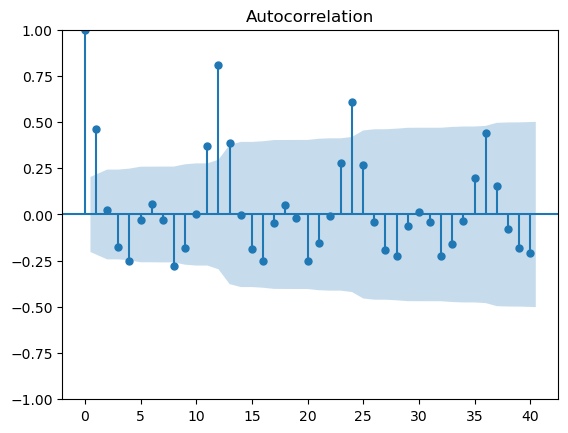

In [20]:
plot_acf(series, lags=40)
pyplot.show()

**Checando Estacionariedade**

In [21]:
import pandas.util.testing as tm
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(series.values)
print('\nADF teste: %f' % resultado[0])
print('\np-value: %f' % resultado[1])
print('\nCritical Values:')
for key, value in resultado[4].items():
    print('\t%s: %.3f' % (key, value))


ADF teste: -1.445970

p-value: 0.560050

Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586


**Especificando um Baseline**
- Um baseline é um valor simples que temos para começar o nosso projeto.
- Serve de referência para saber como nosso modelo está se saindo.
- Exemplo: Valor de previsão é o valor anterior, no nosso caso, o valor do mês anterior.

In [23]:
# atribui os dados a variável X 
X = series.values

In [24]:
# define o tamanho do conjunto de treino (50% dos dados para treino e teste)
train_size = int(len(X) * 0.50)

In [25]:
# cria os conjuntos de treino e teste
train = X[0:train_size]
test = X[train_size:]

In [26]:
# obtem todos od dados do treino 
history = [x for x in train]

In [27]:
# imprime os 10 primeiros valores da variável history
history[:10]

[2815, 2672, 2755, 2721, 2946, 3036, 2282, 2212, 2922, 4301]

In [28]:
# imprime o último valor da variável history
history[-1]

5428

In [29]:
# cria lista de previsões
predictions = list()

In [30]:
# aplicando o modelo naive
for i in range(len(test)):
  
    # valor_predito recebe o último valor do conjunto de treino
    valor_predito = history[-1]

    # a primeira previsão é o último valor do conjunto de treino
    predictions.append(valor_predito)

    # valor real recebe o valor atual do teste.
    valor_real = test[i]

    # adiciona o valor real para a lista de historico
    history.append(valor_real)

    # imprime valor predito e valor real..
    print('Valor Predito=%.3f, Valor }Esperado=%3.f' % (valor_predito, valor_real))

Valor Predito=5428.000, Valor }Esperado=8314
Valor Predito=8314.000, Valor }Esperado=10651
Valor Predito=10651.000, Valor }Esperado=3633
Valor Predito=3633.000, Valor }Esperado=4292
Valor Predito=4292.000, Valor }Esperado=4154
Valor Predito=4154.000, Valor }Esperado=4121
Valor Predito=4121.000, Valor }Esperado=4647
Valor Predito=4647.000, Valor }Esperado=4753
Valor Predito=4753.000, Valor }Esperado=3965
Valor Predito=3965.000, Valor }Esperado=1723
Valor Predito=1723.000, Valor }Esperado=5048
Valor Predito=5048.000, Valor }Esperado=6922
Valor Predito=6922.000, Valor }Esperado=9858
Valor Predito=9858.000, Valor }Esperado=11331
Valor Predito=11331.000, Valor }Esperado=4016
Valor Predito=4016.000, Valor }Esperado=3957
Valor Predito=3957.000, Valor }Esperado=4510
Valor Predito=4510.000, Valor }Esperado=4276
Valor Predito=4276.000, Valor }Esperado=4968
Valor Predito=4968.000, Valor }Esperado=4677
Valor Predito=4677.000, Valor }Esperado=3523
Valor Predito=3523.000, Valor }Esperado=1821
Valor 

In [31]:
# avaliando o modelo naive
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 3186.501


## Prevendo dados com ARIMA com Walk Forward

Visualizando a autocorrelação dos lags.

In [32]:
import pandas.util.testing as tm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

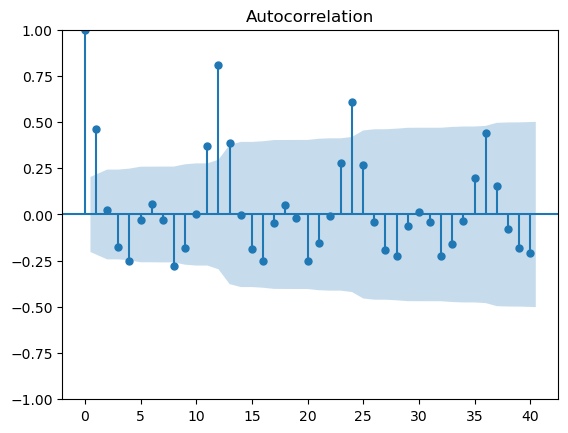

In [33]:
plot_acf(series, lags=40)
pyplot.show()

Separando os dados de treino e teste

In [34]:
series.tail()

Month
1971-05-01    5010
1971-06-01    4874
1971-07-01    4633
1971-08-01    1659
1971-09-01    5951
Name: Sales, dtype: int64

In [35]:
# a variável X recebe os dados da série
X = series.values
X = X.astype('float32')

In [36]:
# Separa os dados com 50% dos dados para treino e 50% dos dados para teste
size = int(len(X) * 0.50)

In [37]:
# Separa dados de treino e teste
train = X[0:size]
test =  X[size:]

In [38]:
# cria a variável history
history = [x for x in train]

In [39]:
# cria lista de previsões
predictions = list()

In [54]:
# Cria a função que faz a diferenciação
def difference(dataset, interval=1):
    diff = list() 
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# cria função que reverte o valor diferenciado para o original
def inverse_difference(history, previsao, interval=1):
    return previsao + history[-interval]

In [48]:
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot

In [55]:
# inicia Walk-Forward
for t in range(len(test)):

    # difference data
    meses_no_ano = 12
    diff = difference(history, meses_no_ano)

    # cria um modelo ARIMA com os dados de history
    model = ARIMA(diff,  order=(1,1,1))
    
    # treina o modelo ARIMA
    model_fit = model.fit()

    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]

    # valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, meses_no_ano)

    # adiciona o valor predito na lista de predicões
    predictions.append(valor_predito)

    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]

    # adiciona o valor real a variável history
    history.append(valor_real)

  # imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=8076.987, Valor esperado=8314
Valor predito=9747.154, Valor esperado=10651
Valor predito=5994.362, Valor esperado=3633
Valor predito=3820.287, Valor esperado=4292
Valor predito=4041.968, Valor esperado=4154
Valor predito=4990.405, Valor esperado=4121
Valor predito=5129.641, Valor esperado=4647
Valor predito=5031.196, Valor esperado=4753
Valor predito=4133.285, Valor esperado=3965
Valor predito=2095.321, Valor esperado=1723
Valor predito=5216.271, Valor esperado=5048
Valor predito=5866.317, Valor esperado=6922
Valor predito=8591.060, Valor esperado=9858
Valor predito=11028.649, Valor esperado=11331
Valor predito=4090.352, Valor esperado=4016
Valor predito=4767.109, Valor esperado=3957
Valor predito=4656.326, Valor esperado=4510
Valor predito=4577.708, Valor esperado=4276
Valor predito=5108.656, Valor esperado=4968
Valor predito=5202.831, Valor esperado=4677
Valor predito=4423.982, Valor esperado=3523
Valor predito=2162.388, Valor esperado=1821
Valor predito=5463.233, Valor

In [56]:
# Avaliando os resultados
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 961.548


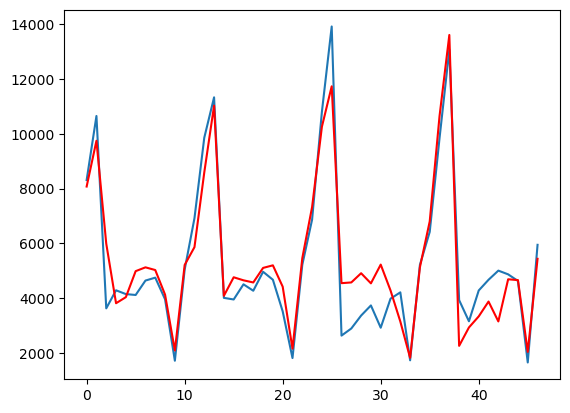

In [57]:
# plot forecasts against actual outcomes 
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

**Código inteiro - Importante**

In [59]:
# cria a variável history
history = [x for x in train]

# cria lista de previsões
predictions = list()

# inicia Walk-Forward
for t in range(len(test)):

    # difference data
    meses_no_ano = 12
    diff = difference(history, meses_no_ano)

    # cria um modelo ARIMA com os dados de history
    model = ARIMA(diff, order=(1,1,1))

    # treina o modelo ARIMA
    model_fit = model.fit()

    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]

    # valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, meses_no_ano)

    # adiciona o valor predito na lista de predicões
    predictions.append(valor_predito)

    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]

    # adiciona o valor real a variável history
    history.append(valor_real)

    # imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=8076.987, Valor esperado=8314
Valor predito=9747.154, Valor esperado=10651
Valor predito=5994.362, Valor esperado=3633
Valor predito=3820.287, Valor esperado=4292
Valor predito=4041.968, Valor esperado=4154
Valor predito=4990.405, Valor esperado=4121
Valor predito=5129.641, Valor esperado=4647
Valor predito=5031.196, Valor esperado=4753
Valor predito=4133.285, Valor esperado=3965
Valor predito=2095.321, Valor esperado=1723
Valor predito=5216.271, Valor esperado=5048
Valor predito=5866.317, Valor esperado=6922
Valor predito=8591.060, Valor esperado=9858
Valor predito=11028.649, Valor esperado=11331
Valor predito=4090.352, Valor esperado=4016
Valor predito=4767.109, Valor esperado=3957
Valor predito=4656.326, Valor esperado=4510
Valor predito=4577.708, Valor esperado=4276
Valor predito=5108.656, Valor esperado=4968
Valor predito=5202.831, Valor esperado=4677
Valor predito=4423.982, Valor esperado=3523
Valor predito=2162.388, Valor esperado=1821
Valor predito=5463.233, Valor

###  Tunning Arima



*   GridSearch
*   Teste exaustivo com as combinações de parâmetros (p,d,q)



Cria a função que executa o modelo Arima

In [60]:
def evaluate_arima_model(X, arima_order):
    # converte o conjunto de dados
    X = X.astype('float32')
    # Separa os dados com 50% dos dados para treino e 50% para teste 
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train] 
    # cria a lista de previsões
    predictions = list()
    for t in range(len(test)):
        # aplica diferenciação nos dados
        months_in_year = 12
        diff = difference(history, months_in_year)
        # treina o modelo ARIMA
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        # recebe os dados previtos pelo modelo
        valor_previsto = model_fit.forecast()[0]
        valor_previsto = inverse_difference(history, valor_previsto, months_in_year)
        # adiciona os dados na lista de previsões
        predictions.append(valor_previsto)
        history.append(test[t])
        # calculate o erro rmse
        rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [61]:
# Loop com combinações de p, d e q para modelo ARIMA
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    # intera sobre todos os valores de p
    for p in p_values:
    # intera sobre todos os valores de d
        for d in d_values:
          # intera sobre todos os valoes de q
          for q in q_values:
            order = (p,d,q)
            try:
                # chama a funcão que executa o ARIMA
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
            except:
                continue 
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [62]:
# Define a lista de valores para cada parâmetro
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)

In [63]:
# elimina os warnings da biblioteca
import warnings
warnings.filterwarnings("ignore")

In [64]:
# chama a funcão passando os parâmetros
evaluate_models(series.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


Executando o modelo com a melhor configuração de ARIMA

In [66]:
# cria a variável history
history = [x for x in train]

# cria lista de previsões
predictions = list()

# inicia Walk-Forward
for t in range(len(test)):
  
    # difference data
    meses_no_ano = 12
    diff = difference(history, meses_no_ano)

    # cria um modelo ARIMA com os dados de history
    model = ARIMA(diff, order=(0,0,1))

    # treina o modelo ARIMA
    model_fit = model.fit()

    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]

    # valor_predito recebe o valor revertido (escala original)
    valor_predito = inverse_difference(history, valor_predito, meses_no_ano)

    # adiciona o valor predito na lista de predicões
    predictions.append(valor_predito)

    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]

    # adiciona o valor real a variável history
    history.append(valor_real)

    # imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=8089.466, Valor esperado=8314
Valor predito=9743.771, Valor esperado=10651
Valor predito=5918.997, Valor esperado=3633
Valor predito=3986.921, Valor esperado=4292
Valor predito=4131.826, Valor esperado=4154
Valor predito=4978.453, Valor esperado=4121
Valor predito=5179.188, Valor esperado=4647
Valor predito=5089.548, Valor esperado=4753
Valor predito=4164.193, Valor esperado=3965
Valor predito=2113.921, Valor esperado=1723
Valor predito=5235.976, Valor esperado=5048
Valor predito=5883.968, Valor esperado=6922
Valor predito=8552.545, Valor esperado=9858
Valor predito=10968.850, Valor esperado=11331
Valor predito=4074.646, Valor esperado=4016
Valor predito=4770.065, Valor esperado=3957
Valor predito=4686.470, Valor esperado=4510
Valor predito=4589.104, Valor esperado=4276
Valor predito=5120.221, Valor esperado=4968
Valor predito=5210.160, Valor esperado=4677
Valor predito=4441.005, Valor esperado=3523
Valor predito=2184.988, Valor esperado=1821
Valor predito=5472.697, Valor

In [67]:
# Avaliando os resultados
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 948.007


#### `Analisando Resíduos`

      Erro Residual = Valor esperado − Valor Predito

- Erros residuais são erros em previsões de séries temporais.
- Uma análise dos erros pode sugerir melhoras no modelo.
  - Tendências.
  - Sazonalidades.

In [68]:
# erros residuais 
residuals = [test[i] - predictions[i] for i in range(len(test))]

In [69]:
# converte a lista em um dataframe
residuals = pd.DataFrame(residuals)

In [70]:
# imprime as 5 primeiras linhas
residuals.head()

,0
0,224.533659
1,907.229043
2,-2285.997177
3,305.078971
4,22.173752


In [71]:
# estatística descritiva
residuals.describe()

,0
count,47.000000
mean,-204.270105
std,935.746182
min,-2325.393963
25%,-709.042279
50%,-228.936186
75%,333.614664
max,2191.022449


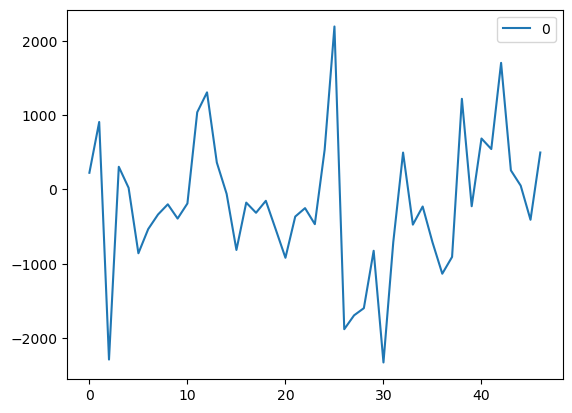

In [72]:
# plot residuals
residuals.plot()
pyplot.show()

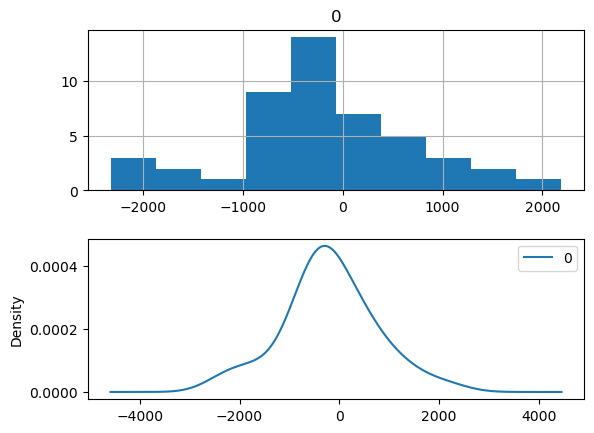

In [73]:
# plots histograma
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())

pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

In [74]:
# importa os pacotes de autocorrelação
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

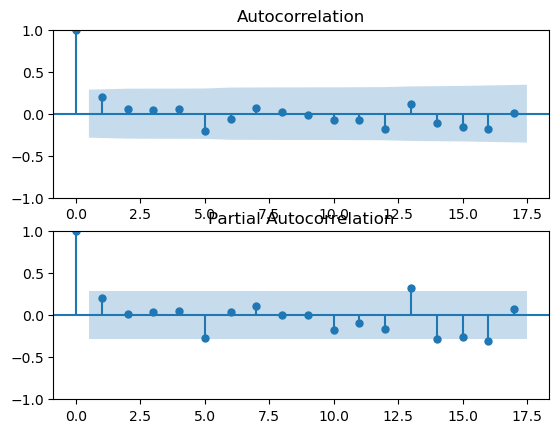

In [75]:
# plots de autocorrelação
pyplot.figure() 
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

Decompondo a série de erro residual

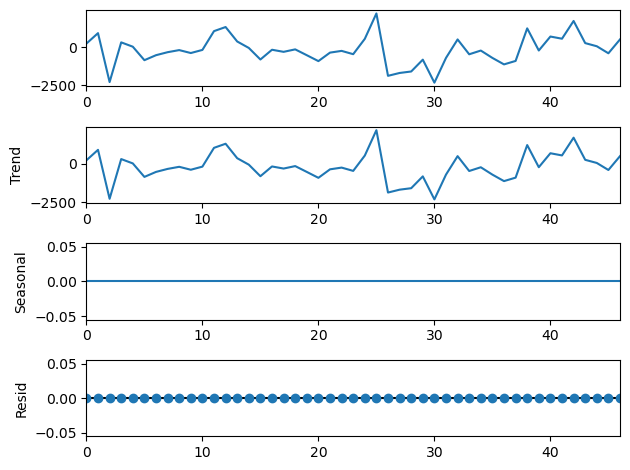

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals.index.freq = 'D'

result = seasonal_decompose(residuals, model='additive', period=1)
result.plot()
pyplot.show()

**SARIMA**

```
# ARIMA(p,d,q)
```
*   **p:** O número de lags que foram devem ser incluídos no modelo.
*   **d:** O número de vezes que as observações serão diferenciadas.
*   **q:** O tamanho de uma janela de média móvel. Também chamada de ordem de média móvel.

SARIMA(p, d, q).(P,D,Q)m


> - SARIMA é usado para séries não estacionárias, que é os dados não flutuam em volta da média. Esse modelo pode identificar tendência e sazonalizadade.

> - Porque considerar a sazonalidade é importante?

A sazonalidade é importante principalmente quando sabemos que as vendas aumentam ou diminuiem em determinados eventos (feriados, inverno, verão, etc). Podemos querer modelar esses fenômenos.

`Exemplo: Não gostaríamos de comparar as vendas do primeiro trimestre de 2020 com as do quarto trimestre de 2019 sem ajustar esse pico sistemático - sem levar em consideração a sazonalidade, assumiríamos por engano que as vendas diminuiram muito (e nossa empresa estava com grandes problemas) quando realmente é apenas a ressaca pós-feriado prevista.`



In [83]:
import statsmodels.api as sm

In [84]:
# cria a variável history
history = [x for x in train]

# cria lista de previsões
predictions = list()

# inicia Walk-Forward
for t in range(len(test)):
  
    # difference data
    meses_no_ano = 12

    # cria um modelo SARIMA com os dados de history
    # desliga a diferenciação do modelo ARIMA
    model = sm.tsa.statespace.SARIMAX(history, order=(1,0,1), seasonal_order=(1,1,1, meses_no_ano))

    # treina o modelo SARIMAX
    model_fit = model.fit(trend='nc', disp=0)

    # a variável valor_predito recebe o valor previsto pelo modelo
    valor_predito = model_fit.forecast()[0]

    # adiciona o valor predito na lista de predicões
    predictions.append(valor_predito)

    # a variável valor_real recebe o valor real do teste
    valor_real = test[t]

    # adiciona o valor real a variável history
    history.append(valor_real)

    # imprime valor predito e valor real
    print('Valor predito=%.3f, Valor esperado=%3.f' % (valor_predito, valor_real))

Valor predito=8228.053, Valor esperado=8314
Valor predito=10253.606, Valor esperado=10651
Valor predito=5986.685, Valor esperado=3633
Valor predito=3530.404, Valor esperado=4292
Valor predito=4182.354, Valor esperado=4154
Valor predito=4977.026, Valor esperado=4121
Valor predito=4961.446, Valor esperado=4647
Valor predito=4972.602, Valor esperado=4753
Valor predito=4089.020, Valor esperado=3965
Valor predito=2138.722, Valor esperado=1723
Valor predito=5196.711, Valor esperado=5048
Valor predito=5833.878, Valor esperado=6922
Valor predito=8861.388, Valor esperado=9858
Valor predito=11529.979, Valor esperado=11331
Valor predito=3894.964, Valor esperado=4016
Valor predito=4644.261, Valor esperado=3957
Valor predito=4543.448, Valor esperado=4510
Valor predito=4498.862, Valor esperado=4276
Valor predito=5047.270, Valor esperado=4968
Valor predito=5166.967, Valor esperado=4677
Valor predito=4390.363, Valor esperado=3523
Valor predito=1824.725, Valor esperado=1821
Valor predito=5497.838, Valo

In [85]:
# Avaliando os resultados
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 890.451


**Facebook Prophet**

- Biblioteca criada pelo Facebook com o objetivo de ser usada na rede social.
- Motivação: Facilitar a criação de modelos sem necessariamente ter experts para isso.
- Focada em modelar sazonalidades, efeitos de feriados e tratar missing values.

In [87]:
!pip install fbprophet

     ---------------------------------------- 64.0/64.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 47.9/47.9 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.4/1.4 MB 22.5 MB/s eta 0:00:00
     ---------------------------------------- 91.8/91.8 kB 5.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
     --------------------------------------- 16.2/16.2 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py):

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [345 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  --- Logging error ---
  Traceback (most recent call last):
    File "C:\Users\Marcio Rodrigues\anaconda3\lib\logging\__init__.py", line 1086, in emit
      stream.write(msg + self.terminator)
  ValueError: underlying buffer has been detached
  Call stack:
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Marcio Rodrigues\AppData\Local\Temp\pip-install-h5zny78k\fbprophet_a6e376192e6046378c2e423f5a5ef723\setup.py", line 122, in <module>
      setup(
    File "C:\Users\Marcio Rodrigues\anaconda3\lib\site-packages\setuptools\__init__.py", line 87, in setup
      return distutils.core.setup(**attrs)
    File "C:\Users\Mar

In [86]:
# importa o Prophet
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# ds: features temporais
# y: valores a serem preditos

dataframe = pd.DataFrame({'ds': dataset.index, 'y': dataset.values})

In [ ]:
# dataframe do prophet
dataframe.head()

In [ ]:
# instancia o objeto prophet
model = Prophet()

In [ ]:
# gerando o modelo
model.fit(dataframe)

In [ ]:
# gerando dados futuros
futuro = model.make_future_dataframe(periods = 12, freq='M')

In [ ]:
futuro

In [ ]:
# prevendo valores para dados futuros
saida = model.predict(futuro)

In [ ]:
# imprime saidas
saida.head()

In [ ]:
saida[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

**Validando o modelo com Prophet**

In [ ]:
# dataset de validação
validation_df = pd.DataFrame({'ds': validation.index})

In [ ]:
# dados temporais
validation_df['ds']

In [ ]:
# aplicando o modelo do prophet
saida = model.predict(validation_df)

In [ ]:
# imprime as saidas
saida[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
validation

In [ ]:
# Avaliando os resultados
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(validation.values, saida.yhat))
print('Test RMSE: %.3f' % rmse)

**Prevendo o futuro**

In [ ]:
# Python
figura = model.plot(saida)

In [ ]:
model.plot_components(saida)

### Tunning do Prophet

- `seasonality_mode`: Este parâmetro indica como seus componentes de sazonalidade devem ser integrados às previsões. O valor padrão é `additive`, com o parâmetro `multiplicative` sendo a outra opção. Você deve usar o  aditivo quando sua tendência de sazonalidade for "constante" durante todo o período. Por exemplo, quando você deseja que seu impacto no crescimento da tendência anual seja o mesmo que em 2010 e 2018. Isso é aplicável nos dados em que a mudança de tendência parece permanecer constante, por exemplo, o número de pessoas que vivem em uma cidade pequena. Isso ocorre porque não esperamos que o crescimento aumente repentinamente em milhões, porque não há infraestrutura para isso. Por outro lado, quando queremos prever a quantidade de pessoas que vivem em uma cidade em crescimento, o número anual de tendências pode ser muito mais importante nos últimos anos, pois a infraestrutura existe. A taxa de crescimento populacional pode ser muito mais rápida do que teria sido nos primeiros anos. Em um caso como esse, você usará multiplicativo para aumentar a importância das sazonalidades ao longo do tempo. 

- `seasonality_prior_scale`. Este parâmetro novamente permitirá que suas sazonalidades sejam mais flexíveis. É possível definir os parâmetros `anual_seasonality`, `Weekly_seasonality` e `daily_seasonality` separadamente ou ainda adiciona sua própria configuração de sazonalidade.

In [ ]:
from fbprophet import Prophet

In [ ]:
import pandas as pd
dataframe = pd.DataFrame({'ds': dataset.index, 'y': dataset.values})

In [ ]:
dataframe

Alterando o modo de sazonalidade

In [ ]:
model = Prophet(seasonality_mode='multiplicative')

In [ ]:
model.fit(dataframe)

In [ ]:
validation_df = pd.DataFrame({'ds': validation.index})

In [ ]:
saida = model.predict(validation_df)

In [ ]:
# Avaliando os resultados
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(validation.values, saida.yhat))
print('Test RMSE: %.3f' % rmse)

Alterando tipos de sazonalidade

In [ ]:
# cria um modelo com sazonalidade  multiplicativa e desligando a sazonalidade diária
model = Prophet(seasonality_mode='multiplicative', daily_seasonality=False, )

In [ ]:
model.fit(dataframe)

In [ ]:
# imprime a sazonalidade habilitada
model.seasonalities

In [ ]:
# cria o dataframe de validação
validation_df = pd.DataFrame({'ds': validation.index})

In [ ]:
# prevendo dados
saida = model.predict(validation_df)

In [ ]:
# Avaliando os resultados
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(validation.values, saida.yhat))
print('Test RMSE: %.3f' % rmse)